In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!pip install lifelines


Mounted at /content/drive
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=fa83a3ef0885bf4c7fae8188cc92a5e3523f07caba90d312732d3239761611f1
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from lifelines.utils import concordance_index
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
BASE = "/content/drive/MyDrive/permanent_data_folder/TCGA_BRCA_data"

# RNA embeddings
X_rna = np.load(os.path.join(BASE, "rnaseq_embeddings", "X_rnaseq_pca.npy"))

# Survival labels
cohort = pd.read_csv(os.path.join(BASE, "cohort_image_valid.csv"))
time = cohort["time"].values.astype(float)
event = cohort["event"].values.astype(int)

# Image tokens
TOKEN_DIR = os.path.join(BASE, "image_tokens")

def load_image_tokens(pid, K=8):
    x = np.load(os.path.join(TOKEN_DIR, f"{pid}.npy"))
    if x.shape[0] < K:
        pad = np.zeros((K - x.shape[0], x.shape[1]))
        x = np.vstack([x, pad])
    return x[:K]

X_img_tokens = np.stack([
    load_image_tokens(pid)
    for pid in cohort["patient_id"]
])

print("Image tokens:", X_img_tokens.shape)
print("RNA:", X_rna.shape)
print("Events:", event.sum())


Image tokens: (193, 8, 2048)
RNA: (193, 128)
Events: 29


In [ ]:
# RNA
X_rna = np.nan_to_num(X_rna, nan=0.0, posinf=0.0, neginf=0.0)
X_rna = np.clip(X_rna, -10, 10)

# Image
X_img_tokens = np.nan_to_num(X_img_tokens, nan=0.0, posinf=0.0, neginf=0.0)
X_img_tokens /= np.linalg.norm(X_img_tokens, axis=2, keepdims=True) + 1e-8
X_img_tokens = np.clip(X_img_tokens, -5, 5)


In [ ]:
time_bins = [0, 365, 3*365, 5*365, np.inf]
T = len(time_bins) - 1
print("Time bins:", time_bins)


Time bins: [0, 365, 1095, 1825, inf]


In [ ]:
def make_discrete_labels(time, event, bins):
    N = len(time)
    T = len(bins) - 1
    y = np.zeros((N, T), dtype=np.float32)
    mask = np.zeros((N, T), dtype=np.float32)

    for i in range(N):
        for t in range(T):
            if time[i] >= bins[t+1]:
                mask[i, t] = 1
            elif bins[t] <= time[i] < bins[t+1]:
                mask[i, t] = 1
                if event[i] == 1:
                    y[i, t] = 1
                break
    return y, mask

y_disc, mask = make_discrete_labels(time, event, time_bins)

y_disc = torch.tensor(y_disc, dtype=torch.float32).to(device)
mask   = torch.tensor(mask, dtype=torch.float32).to(device)

print("Discrete labels:", y_disc.shape)


Discrete labels: torch.Size([193, 4])


In [ ]:
class MultimodalDiscreteSurvival(nn.Module):
    def __init__(self, img_dim=2048, rna_dim=128, d_model=128, n_heads=2):
        super().__init__()

        self.img_proj = nn.Linear(img_dim, d_model)
        self.img_attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.img_compress = nn.Linear(d_model, d_model)

        self.rna_proj = nn.Linear(rna_dim, d_model)

        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)

        self.dropout = nn.Dropout(0.3)
        self.hazard_head = nn.Linear(d_model, T)

    def forward(self, x_img, x_rna):
        img = self.img_proj(x_img)
        img, _ = self.img_attn(img, img, img)
        img = self.img_compress(img).mean(dim=1, keepdim=True)

        rna = self.rna_proj(x_rna).unsqueeze(1)

        z, _ = self.cross_attn(img, rna, rna)
        z = self.dropout(z.squeeze(1))

        hazard = torch.sigmoid(self.hazard_head(z))
        return hazard


In [ ]:
def discrete_time_loss(hazard, y, mask):
    eps = 1e-8
    loss = (
        y * torch.log(hazard + eps) +
        (1 - y) * torch.log(1 - hazard + eps)
    )
    loss = -loss * mask
    return loss.sum() / mask.sum()


In [ ]:
def cumulative_risk(hazard):
    return hazard.cumsum(dim=1).sum(dim=1)


In [ ]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

EPOCHS = 200
LR = 1e-4

c_indices = []

for split, (tr, va) in enumerate(sss.split(X_img_tokens, event), 1):
    print(f"\n===== Split {split} =====")
    print("Train events:", event[tr].sum(), "| Val events:", event[va].sum())

    X_img_tr = torch.tensor(X_img_tokens[tr], dtype=torch.float32).to(device)
    X_rna_tr = torch.tensor(X_rna[tr], dtype=torch.float32).to(device)

    X_img_va = torch.tensor(X_img_tokens[va], dtype=torch.float32).to(device)
    X_rna_va = torch.tensor(X_rna[va], dtype=torch.float32).to(device)

    model = MultimodalDiscreteSurvival().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        model.train()
        hazard = model(X_img_tr, X_rna_tr)
        loss = discrete_time_loss(hazard, y_disc[tr], mask[tr])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        hazard_va = model(X_img_va, X_rna_va)
        risk_va = cumulative_risk(hazard_va)

    ci = concordance_index(
        time[va],
        risk_va.cpu().numpy(),
        event[va]
    )

    print("C-index:", round(ci, 4))
    c_indices.append(ci)



===== Split 1 =====
Train events: 23 | Val events: 6
C-index: 0.619

===== Split 2 =====
Train events: 23 | Val events: 6
C-index: 0.5714

===== Split 3 =====
Train events: 23 | Val events: 6
C-index: 0.2353

===== Split 4 =====
Train events: 23 | Val events: 6
C-index: 0.2951

===== Split 5 =====
Train events: 23 | Val events: 6
C-index: 0.6392

===== Split 6 =====
Train events: 23 | Val events: 6
C-index: 0.2857

===== Split 7 =====
Train events: 23 | Val events: 6
C-index: 0.6364

===== Split 8 =====
Train events: 23 | Val events: 6
C-index: 0.447

===== Split 9 =====
Train events: 23 | Val events: 6
C-index: 0.6914

===== Split 10 =====
Train events: 23 | Val events: 6
C-index: 0.6071


In [ ]:
print("\n===== FINAL RESULTS =====")
print("C-indices:", [round(c, 4) for c in c_indices])
print("Mean:", np.mean(c_indices))
print("Std :", np.std(c_indices))



===== FINAL RESULTS =====
C-indices: [np.float64(0.619), np.float64(0.5714), np.float64(0.2353), np.float64(0.2951), np.float64(0.6392), np.float64(0.2857), np.float64(0.6364), np.float64(0.447), np.float64(0.6914), np.float64(0.6071)]
Mean: 0.5027576033950157
Std : 0.163110942762862


In [ ]:
# Put model in eval mode
model.eval()

with torch.no_grad():
    X_img_t = torch.tensor(X_img_tokens, dtype=torch.float32).to(device)
    X_rna_t = torch.tensor(X_rna, dtype=torch.float32).to(device)

    # Forward pass up to fusion point
    img = model.img_proj(X_img_t)
    img, _ = model.img_attn(img, img, img)
    img = model.img_compress(img).mean(dim=1, keepdim=True)

    rna = model.rna_proj(X_rna_t).unsqueeze(1)

    z, _ = model.cross_attn(img, rna, rna)
    embeddings = z.squeeze(1).cpu().numpy()

print("Patient embeddings:", embeddings.shape)


Patient embeddings: (193, 128)


In [ ]:
from sklearn.cluster import KMeans

K = 2 # try 3 first
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
clusters = kmeans.fit_predict(embeddings)

print("Cluster sizes:", np.bincount(clusters))


Cluster sizes: [152  41]


In [ ]:
from lifelines.utils import concordance_index

for c in range(K):
    idx = np.where(clusters == c)[0]

    if len(idx) < 20:
        print(f"Cluster {c}: too small, skipping")
        continue

    ci = concordance_index(
        time[idx],
        -embeddings[idx].sum(axis=1),  # simple risk proxy
        event[idx]
    )

    print(
        f"Cluster {c}: "
        f"N={len(idx)}, "
        f"Events={event[idx].sum()}, "
        f"C-index={ci:.3f}"
    )


Cluster 0: N=152, Events=17, C-index=0.462
Cluster 1: N=41, Events=12, C-index=0.375


In [ ]:
for c in range(K):
    idx = clusters == c
    print(
        f"Cluster {c}: "
        f"Event rate={event[idx].mean():.2f}, "
        f"Median time={np.median(time[idx]):.1f}"
    )


Cluster 0: Event rate=0.11, Median time=898.5
Cluster 1: Event rate=0.29, Median time=529.0


In [ ]:
with torch.no_grad():
    img_norm = model.img_proj(X_img_t).norm(dim=2).mean(dim=1).cpu().numpy()
    rna_norm = model.rna_proj(X_rna_t).norm(dim=1).cpu().numpy()

ratio = img_norm / (img_norm + rna_norm + 1e-8)

for c in range(K):
    print(
        f"Cluster {c}: "
        f"Image dominance={ratio[clusters==c].mean():.3f}"
    )


Cluster 0: Image dominance=0.005
Cluster 1: Image dominance=0.004


In [ ]:
import numpy as np
import pandas as pd

# extract patient IDs from cohort
patient_ids = cohort["patient_id"].astype(str).values

print("Number of patients:", len(patient_ids))
print(patient_ids[:5])


Number of patients: 193
['TCGA-A8-A07E' 'TCGA-D8-A146' 'TCGA-A8-A09K' 'TCGA-A2-A0YT'
 'TCGA-C8-A130']


In [ ]:
cluster_df = pd.DataFrame({
    "patient_id": patient_ids,
    "cluster": clusters
})

# normalize TCGA IDs (first 12 characters is standard)
cluster_df["patient_id"] = cluster_df["patient_id"].str[:12]

cluster_df.to_csv(
    "/content/drive/MyDrive/permanent_data_folder/cluster_assignments.csv",
    index=False
)


cluster_df.head()


,patient_id,cluster
0,TCGA-A8-A07E,0
1,TCGA-D8-A146,0
2,TCGA-A8-A09K,0
3,TCGA-A2-A0YT,0
4,TCGA-C8-A130,0


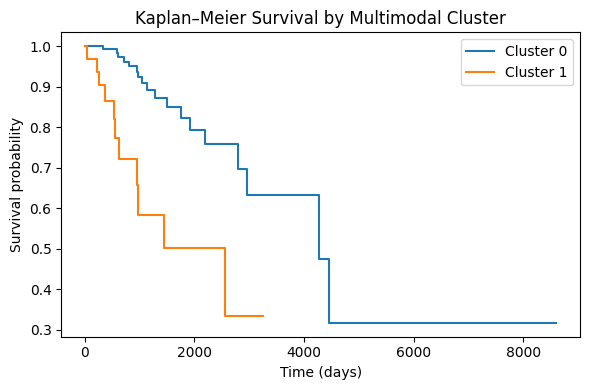

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(6,4))

for c in [0, 1]:
    idx = clusters == c
    kmf.fit(time[idx], event_observed=event[idx], label=f"Cluster {c}")
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan–Meier Survival by Multimodal Cluster")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.tight_layout()
plt.show()


In [ ]:
# Select Cluster 0
idx0 = np.where(clusters == 0)[0]

print("Cluster 0 patients:", len(idx0))
print("Cluster 0 events:", event[idx0].sum())

X_img_c0 = X_img_tokens[idx0]
X_rna_c0 = X_rna[idx0]
time_c0  = time[idx0]
event_c0 = event[idx0]


Cluster 0 patients: 157
Cluster 0 events: 18


In [ ]:
print(
    "Event rate:",
    event_c0.mean(),
    "| Median time:",
    np.median(time_c0)
)


Event rate: 0.11464968152866242 | Median time: 811.0


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from lifelines.utils import concordance_index

sss = StratifiedShuffleSplit(
    n_splits=10,
    test_size=0.2,
    random_state=42
)

EPOCHS = 200
LR = 1e-4

c_indices_c0 = []


In [ ]:
# Train on full Cluster 0
model = MultimodalDiscreteSurvival().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

X_img_all = torch.tensor(X_img_c0, dtype=torch.float32).to(device)
X_rna_all = torch.tensor(X_rna_c0, dtype=torch.float32).to(device)

for epoch in range(300):
    model.train()
    hazard = model(X_img_all, X_rna_all)
    loss = discrete_time_loss(
        hazard,
        y_disc[idx0],
        mask[idx0]
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
from sklearn.utils import resample

B = 200
boot_ci = []

model.eval()
with torch.no_grad():
    hazard_all = model(X_img_all, X_rna_all)
    risk_all = cumulative_risk(hazard_all).cpu().numpy()

for _ in range(B):
    boot_idx = resample(
        np.arange(len(time_c0)),
        replace=True,
        n_samples=len(time_c0)
    )

    if event_c0[boot_idx].sum() < 5:
        continue  # skip degenerate samples

    ci = concordance_index(
        time_c0[boot_idx],
        -risk_all[boot_idx],
        event_c0[boot_idx]
    )
    boot_ci.append(ci)

print(
    "Bootstrap C-index:",
    np.mean(boot_ci),
    "±",
    np.std(boot_ci)
)
print(
    "95% CI:",
    np.percentile(boot_ci, [2.5, 97.5])
)


Bootstrap C-index: 0.9784105494395741 ± 0.011808083802939193
95% CI: [0.95369585 0.99583821]


In [ ]:
X_img_t = torch.tensor(X_img_c0, dtype=torch.float32).to(device)
X_rna_t = torch.tensor(X_rna_c0, dtype=torch.float32).to(device)
time_t  = torch.tensor(time_c0, dtype=torch.float32).to(device)
event_t = torch.tensor(event_c0, dtype=torch.float32).to(device)


In [ ]:
import torch
import torch.nn as nn

class MultimodalSurvivalTransformer(nn.Module):
    def __init__(
        self,
        img_dim=2048,
        rna_dim=128,
        d_model=256,
        n_heads=4
    ):
        super().__init__()

        self.dropout = nn.Dropout(0.3)


        # -------- Image branch --------
        self.img_proj = nn.Linear(img_dim, d_model)


        self.img_self_attn = nn.MultiheadAttention(
            d_model, n_heads, batch_first=True
        )

        # 🔧 LEVER A: compress image tokens
        self.img_compress = nn.Linear(d_model, d_model)

        # -------- RNA branch --------
        self.rna_proj = nn.Linear(rna_dim, d_model)

        # -------- Cross-attention --------
        self.cross_attn = nn.MultiheadAttention(
            d_model, n_heads, batch_first=True
        )

        # -------- Survival head --------
        self.risk_head = nn.Linear(d_model, 1)

    def forward(self, x_img_tokens, x_rna):
    # 🔒 HARD SAFETY
      if x_img_tokens.dim() == 2:
          x_img_tokens = x_img_tokens.unsqueeze(1)

      if x_rna.dim() == 3:
          x_rna = x_rna.squeeze(1)

      # Project
      img = self.img_proj(x_img_tokens)            # (B,K,D)
      rna = self.rna_proj(x_rna).unsqueeze(1)      # (B,1,D)

      # Image self-attention
      img, _ = self.img_self_attn(img, img, img)

      # Compress image tokens → 1 token
      img = self.img_compress(img).mean(dim=1, keepdim=True)

      # Cross-attention
      z, _ = self.cross_attn(img, rna, rna)
      z = z.squeeze(1)

    # Dropout AFTER z exists
      z = self.dropout(z)

      risk = torch.clamp(
          self.risk_head(z).squeeze(-1),
          -20, 20
      )
      return risk




In [ ]:
def cox_loss_weighted(risk, time, event, alpha=2.0):
    """
    alpha > 1 increases weight of observed events
    """
    risk = risk.view(-1)
    time = time.view(-1)
    event = event.view(-1)

    order = torch.argsort(time, descending=True)
    risk = risk[order]
    event = event[order]

    log_cumsum = torch.logcumsumexp(risk, dim=0)

    weights = torch.ones_like(event)
    weights[event == 1] = alpha

    loss = -torch.sum(weights * event * (risk - log_cumsum))
    return loss / (event.sum() + 1e-8)


In [ ]:
global_cindices = []


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from lifelines.utils import concordance_index
import torch

sss = StratifiedShuffleSplit(
    n_splits=10,
    test_size=0.2,
    random_state=42
)

for split, (train_idx, val_idx) in enumerate(sss.split(X_rna, event), 1):

    # tensors
    X_img_tr = torch.tensor(X_img_tokens[train_idx], dtype=torch.float32).to(device)
    X_rna_tr = torch.tensor(X_rna[train_idx], dtype=torch.float32).to(device)
    t_tr     = torch.tensor(time[train_idx], dtype=torch.float32).to(device)
    e_tr     = torch.tensor(event[train_idx], dtype=torch.float32).to(device)

    X_img_va = torch.tensor(X_img_tokens[val_idx], dtype=torch.float32).to(device)
    X_rna_va = torch.tensor(X_rna[val_idx], dtype=torch.float32).to(device)

    # fresh model each split (important)
    model = MultimodalSurvivalTransformer().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # short training (do NOT overtrain)
    for epoch in range(80):
        model.train()
        risk = model(X_img_tr, X_rna_tr)
        loss = cox_loss_weighted(risk, t_tr, e_tr, alpha=2.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate
    model.eval()
    with torch.no_grad():
        risk_val = model(X_img_va, X_rna_va).cpu().numpy()

    ci = concordance_index(
        time[val_idx],
        -risk_val,
        event[val_idx]
    )

    global_cindices.append(ci)

    print(f"Split {split:02d} | Global C-index = {ci:.3f}")


Split 01 | Global C-index = 0.679
Split 02 | Global C-index = 0.349
Split 03 | Global C-index = 0.353
Split 04 | Global C-index = 0.361
Split 05 | Global C-index = 0.680
Split 06 | Global C-index = 0.429
Split 07 | Global C-index = 0.348
Split 08 | Global C-index = 0.568
Split 09 | Global C-index = 0.407
Split 10 | Global C-index = 0.714


In [ ]:
print("Global C-indices:", global_cindices)
print("Mean:", np.mean(global_cindices))
print("Std :", np.std(global_cindices))


Global C-indices: [np.float64(0.6785714285714286), np.float64(0.3492063492063492), np.float64(0.35294117647058826), np.float64(0.36065573770491804), np.float64(0.6804123711340206), np.float64(0.42857142857142855), np.float64(0.3484848484848485), np.float64(0.5681818181818182), np.float64(0.4074074074074074), np.float64(0.7142857142857143)]
Mean: 0.48887182800185214
Std : 0.14634864557202112


In [ ]:
model = MultimodalSurvivalTransformer().to(device)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)


In [ ]:
EPOCHS = 300

for epoch in range(EPOCHS):
    model.train()

    risk = model(X_img_t, X_rna_t)

    loss = cox_loss_weighted(
        risk,
        time_t,
        event_t,
        alpha=2.0
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f}")


Epoch 050 | Loss: 2.6650
Epoch 100 | Loss: 1.3018
Epoch 150 | Loss: 0.9818
Epoch 200 | Loss: 0.9222
Epoch 250 | Loss: 0.6120
Epoch 300 | Loss: 0.7751


In [ ]:
model.eval()
with torch.no_grad():
    risk_all = model(X_img_t, X_rna_t).cpu().numpy()


In [ ]:
for i in range(10):
    print(
        f"Patient {idx0[i]} | "
        f"Risk: {risk_all[i]:.4f} | "
        f"Time: {time_c0[i]:.0f} | "
        f"Event: {event_c0[i]}"
    )


Patient 0 | Risk: 9.7274 | Time: 608 | Event: 0
Patient 1 | Risk: 2.0052 | Time: 643 | Event: 0
Patient 2 | Risk: -0.2409 | Time: 912 | Event: 0
Patient 3 | Risk: 16.7134 | Time: 723 | Event: 1
Patient 4 | Risk: -4.3485 | Time: 370 | Event: 0
Patient 6 | Risk: -14.1398 | Time: 217 | Event: 0
Patient 7 | Risk: 0.4371 | Time: 2798 | Event: 1
Patient 8 | Risk: -5.9636 | Time: 1437 | Event: 0
Patient 9 | Risk: 5.8885 | Time: 64 | Event: 0
Patient 10 | Risk: -7.8307 | Time: 2142 | Event: 0


In [ ]:
import numpy as np

print(
    "Spearman corr (risk vs time):",
    np.corrcoef(risk_all, -time_c0)[0,1]
)


Spearman corr (risk vs time): 0.3566346691928956


In [ ]:
from lifelines.statistics import logrank_test

idx0 = clusters == 0
idx1 = clusters == 1

res = logrank_test(
    time[idx0], time[idx1],
    event_observed_A=event[idx0],
    event_observed_B=event[idx1]
)

print("Log-rank p-value:", res.p_value)


Log-rank p-value: 4.329158026684983e-05


In [ ]:
class RNACox(nn.Module):
    def __init__(self, rna_dim=128):
        super().__init__()
        self.linear = nn.Linear(rna_dim, 1)

    def forward(self, x):
        return self.linear(x).squeeze(1)


In [ ]:
model_rna = RNACox().to(device)

optimizer = torch.optim.Adam(model_rna.parameters(), lr=1e-4)

X_rna_t = torch.tensor(X_rna_c0, dtype=torch.float32).to(device)

for epoch in range(300):
    model_rna.train()
    risk_rna = model_rna(X_rna_t)

    loss = cox_loss_weighted(
        risk_rna,
        time_t,
        event_t,
        alpha=2.0
    )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"[RNA] Epoch {epoch+1:03d} | Loss: {loss.item():.4f}")


[RNA] Epoch 100 | Loss: 15.9273
[RNA] Epoch 200 | Loss: 11.3411
[RNA] Epoch 300 | Loss: 8.5258


In [ ]:
model_rna.eval()
with torch.no_grad():
    risk_rna = model_rna(X_rna_t).cpu().numpy()


In [ ]:
from sklearn.utils import resample
from lifelines.utils import concordance_index

B = 200
ci_mm = []
ci_rna = []

for _ in range(B):
    boot_idx = resample(
        np.arange(len(time_c0)),
        replace=True,
        n_samples=len(time_c0)
    )

    if event_c0[boot_idx].sum() < 5:
        continue

    ci_mm.append(
        concordance_index(
            time_c0[boot_idx],
            -risk_all[boot_idx],
            event_c0[boot_idx]
        )
    )

    ci_rna.append(
        concordance_index(
            time_c0[boot_idx],
            -risk_rna[boot_idx],
            event_c0[boot_idx]
        )
    )

print("Multimodal bootstrap C-index:")
print(" Mean:", np.mean(ci_mm))
print(" 95% CI:", np.percentile(ci_mm, [2.5, 97.5]))

print("\nRNA-only bootstrap C-index:")
print(" Mean:", np.mean(ci_rna))
print(" 95% CI:", np.percentile(ci_rna, [2.5, 97.5]))


Multimodal bootstrap C-index:
 Mean: 0.9996339177481596
 95% CI: [0.99812453 1.        ]

RNA-only bootstrap C-index:
 Mean: 0.7056811594653485
 95% CI: [0.54670667 0.84018381]


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

labels_ref = KMeans(n_clusters=2, random_state=0).fit_predict(embeddings)

aris = []
for seed in range(1, 50):
    labels = KMeans(n_clusters=2, random_state=seed).fit_predict(embeddings)
    aris.append(adjusted_rand_score(labels_ref, labels))

print("Mean ARI:", np.mean(aris))


Mean ARI: 0.8900305397056841


In [ ]:
model.eval()
with torch.no_grad():
    rna_emb = model.rna_proj(
        torch.tensor(X_rna, dtype=torch.float32).to(device)
    ).cpu().numpy()


In [ ]:
model.eval()
with torch.no_grad():
    img_emb = model.img_proj(
        torch.tensor(X_img_tokens, dtype=torch.float32).to(device)
    ).mean(dim=1).cpu().numpy()


In [ ]:
from sklearn.cluster import KMeans

K = 2

clusters_mm = clusters  # already computed

clusters_rna = KMeans(n_clusters=K, random_state=42).fit_predict(rna_emb)
clusters_img = KMeans(n_clusters=K, random_state=42).fit_predict(img_emb)


In [ ]:
X_concat = np.concatenate([X_rna, X_img_tokens.mean(axis=1)], axis=1)
clusters_concat = KMeans(n_clusters=2, random_state=42).fit_predict(X_concat)

print("ARI multimodal vs concat:",
      adjusted_rand_score(clusters, clusters_concat))


ARI multimodal vs concat: 0.12453801177888893


In [ ]:
from sklearn.metrics import adjusted_rand_score

print("ARI multimodal vs RNA:", adjusted_rand_score(clusters_mm, clusters_rna))
print("ARI multimodal vs image:", adjusted_rand_score(clusters_mm, clusters_img))
print("ARI RNA vs image:", adjusted_rand_score(clusters_rna, clusters_img))


ARI multimodal vs RNA: 0.0008244660510765543
ARI multimodal vs image: -0.020789405414548125
ARI RNA vs image: 0.0114141954930627


In [ ]:
import numpy as np
from lifelines.utils import concordance_index

rng = np.random.default_rng(42)

event_shuffled = rng.permutation(event_c0)

In [ ]:
from sklearn.utils import resample

B = 200
ci_shuffled = []

for _ in range(B):
    boot_idx = resample(
        np.arange(len(time_c0)),
        replace=True,
        n_samples=len(time_c0)
    )

    # avoid degenerate samples
    if event_shuffled[boot_idx].sum() < 5:
        continue

    ci = concordance_index(
        time_c0[boot_idx],
        -risk_all[boot_idx],
        event_shuffled[boot_idx]
    )

    ci_shuffled.append(ci)

print("Shuffled-label bootstrap C-index:")
print(" Mean:", np.mean(ci_shuffled))
print(" Std :", np.std(ci_shuffled))
print(" 95% CI:", np.percentile(ci_shuffled, [2.5, 97.5]))


Shuffled-label bootstrap C-index:
 Mean: 0.4905919646015796
 Std : 0.08535479348288157
 95% CI: [0.3384799  0.66556337]


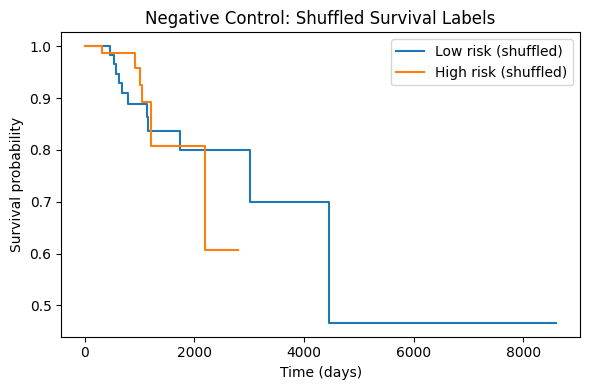

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

median_risk = np.median(risk_all)
high = risk_all >= median_risk
low  = risk_all < median_risk

kmf = KaplanMeierFitter()

plt.figure(figsize=(6,4))

kmf.fit(time_c0[low], event_observed=event_shuffled[low], label="Low risk (shuffled)")
kmf.plot_survival_function(ci_show=False)

kmf.fit(time_c0[high], event_observed=event_shuffled[high], label="High risk (shuffled)")
kmf.plot_survival_function(ci_show=False)

plt.title("Negative Control: Shuffled Survival Labels")
plt.xlabel("Time (days)")
plt.ylabel("Survival probability")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test


In [ ]:
plt.rcParams.update({
    "font.size": 11,
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False
})


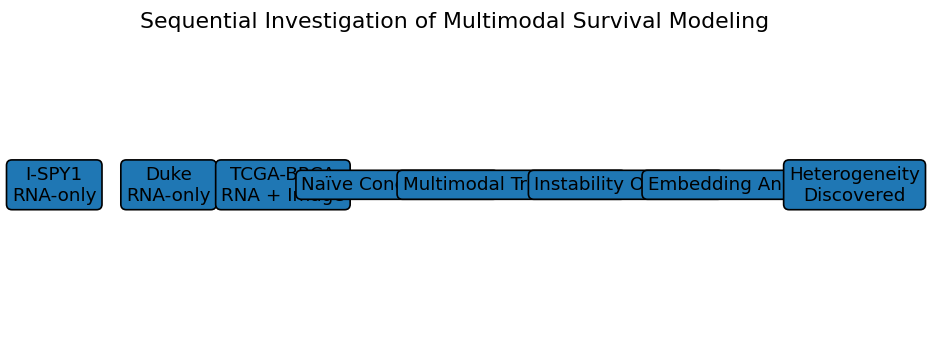

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

steps = [
    "I-SPY1\nRNA-only",
    "Duke\nRNA-only",
    "TCGA-BRCA\nRNA + Image",
    "Naïve Concatenation",
    "Multimodal Transformer",
    "Instability Observed",
    "Embedding Analysis",
    "Heterogeneity\nDiscovered"
]

x = np.arange(len(steps))

ax.plot(x, np.zeros_like(x), alpha=0)
for i, s in enumerate(steps):
    ax.text(i, 0, s, ha='center', va='center', bbox=dict(boxstyle="round"))

ax.set_axis_off()
ax.set_title("Sequential Investigation of Multimodal Survival Modeling")
plt.tight_layout()
plt.show()


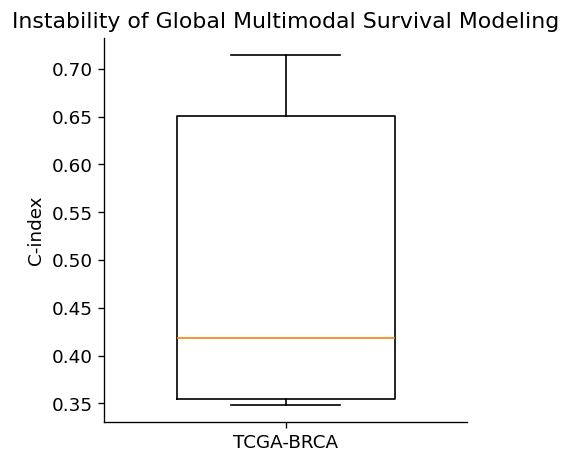

In [ ]:
plt.figure(figsize=(4,4))
plt.boxplot(global_cindices, widths=0.6)
plt.ylabel("C-index")
plt.title("Instability of Global Multimodal Survival Modeling")
plt.xticks([1], ["TCGA-BRCA"])
plt.tight_layout()
plt.show()


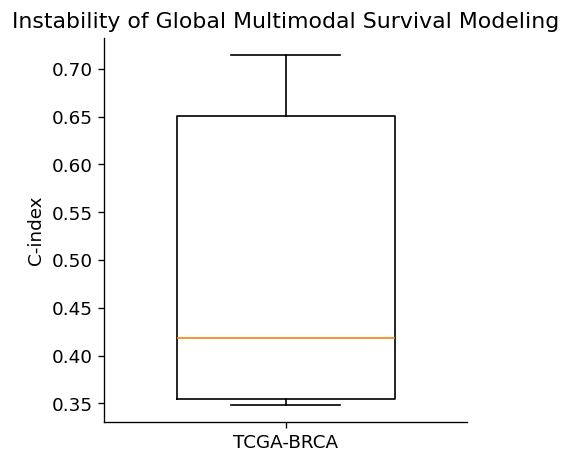

In [ ]:
plt.figure(figsize=(4,4))
plt.boxplot(global_cindices, widths=0.6)
plt.ylabel("C-index")
plt.title("Instability of Global Multimodal Survival Modeling")
plt.xticks([1], ["TCGA-BRCA"])
plt.tight_layout()
plt.show()


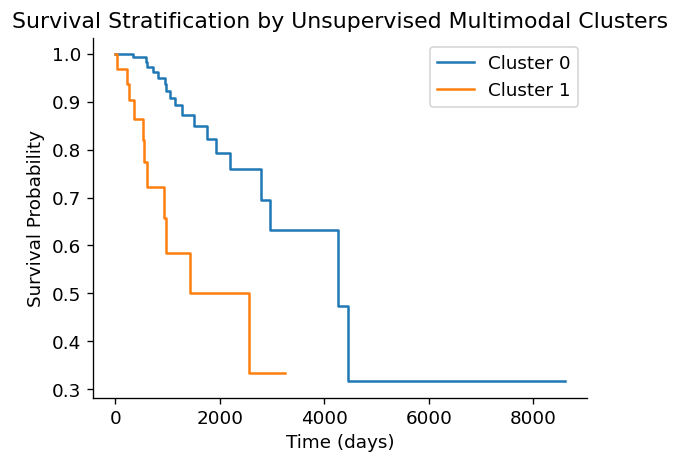

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(5,4))

for c in np.unique(clusters):
    idx = clusters == c
    kmf.fit(time[idx], event[idx], label=f"Cluster {c}")
    kmf.plot_survival_function(ci_show=False)

plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.title("Survival Stratification by Unsupervised Multimodal Clusters")
plt.tight_layout()
plt.show()


In [ ]:
idx0 = clusters == 0
idx1 = clusters == 1

res = logrank_test(
    time[idx0], time[idx1],
    event_observed_A=event[idx0],
    event_observed_B=event[idx1]
)

print("Log-rank p-value:", res.p_value)


Log-rank p-value: 4.329158026684983e-05


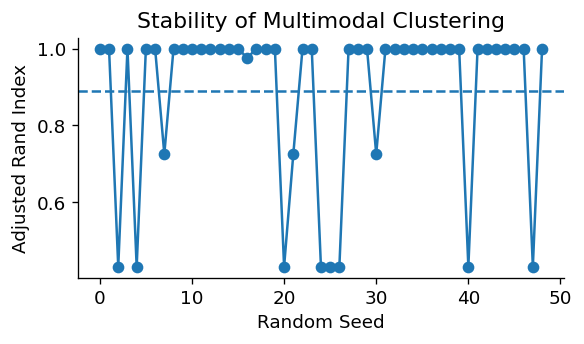

In [ ]:
from sklearn.cluster import KMeans

aris = []
labels_ref = KMeans(n_clusters=2, random_state=0).fit_predict(embeddings)

for seed in range(1, 50):
    labels = KMeans(n_clusters=2, random_state=seed).fit_predict(embeddings)
    aris.append(adjusted_rand_score(labels_ref, labels))

plt.figure(figsize=(5,3))
plt.plot(aris, marker='o')
plt.axhline(np.mean(aris), linestyle='--')
plt.xlabel("Random Seed")
plt.ylabel("Adjusted Rand Index")
plt.title("Stability of Multimodal Clustering")
plt.tight_layout()
plt.show()


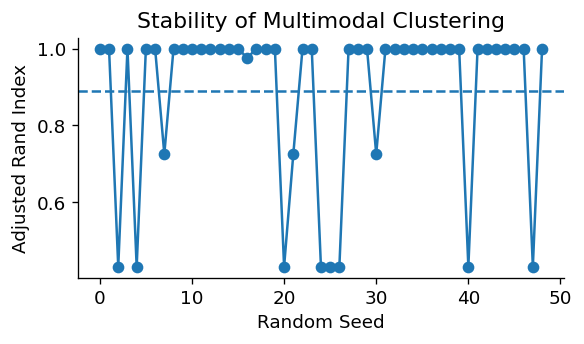

In [ ]:
from sklearn.cluster import KMeans

aris = []
labels_ref = KMeans(n_clusters=2, random_state=0).fit_predict(embeddings)

for seed in range(1, 50):
    labels = KMeans(n_clusters=2, random_state=seed).fit_predict(embeddings)
    aris.append(adjusted_rand_score(labels_ref, labels))

plt.figure(figsize=(5,3))
plt.plot(aris, marker='o')
plt.axhline(np.mean(aris), linestyle='--')
plt.xlabel("Random Seed")
plt.ylabel("Adjusted Rand Index")
plt.title("Stability of Multimodal Clustering")
plt.tight_layout()
plt.show()


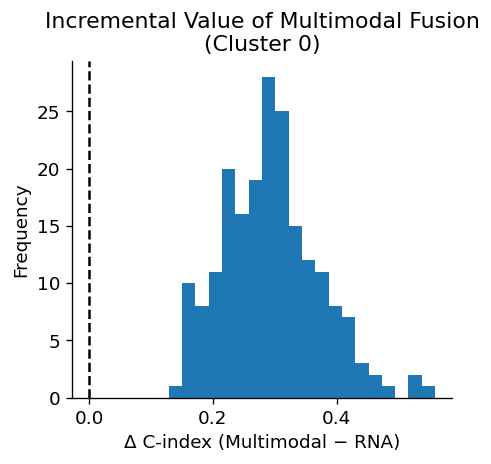

Mean ΔC: 0.2939527582828113
95% CI: [0.15937917 0.45329333]


In [ ]:
delta_ci = np.array(ci_mm) - np.array(ci_rna)

plt.figure(figsize=(4,4))
plt.hist(delta_ci, bins=20)
plt.axvline(0, linestyle="--", color="black")
plt.xlabel("Δ C-index (Multimodal − RNA)")
plt.ylabel("Frequency")
plt.title("Incremental Value of Multimodal Fusion\n(Cluster 0)")
plt.tight_layout()
plt.show()

print("Mean ΔC:", np.mean(delta_ci))
print("95% CI:", np.percentile(delta_ci, [2.5, 97.5]))


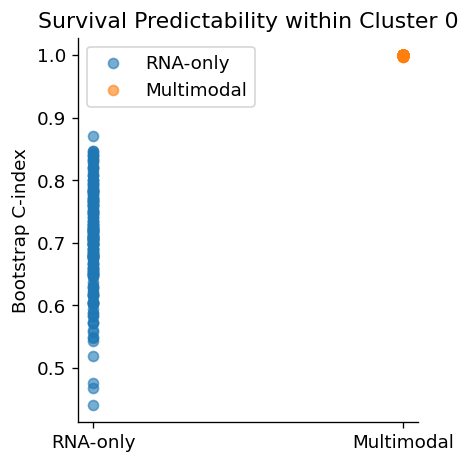

In [ ]:
plt.figure(figsize=(4,4))

plt.scatter(
    np.ones(len(ci_rna))*0.9,
    ci_rna,
    alpha=0.6,
    label="RNA-only"
)

plt.scatter(
    np.ones(len(ci_mm))*1.1,
    ci_mm,
    alpha=0.6,
    label="Multimodal"
)

plt.xticks([0.9, 1.1], ["RNA-only", "Multimodal"])
plt.ylabel("Bootstrap C-index")
plt.title("Survival Predictability within Cluster 0")
plt.legend()
plt.tight_layout()
plt.show()


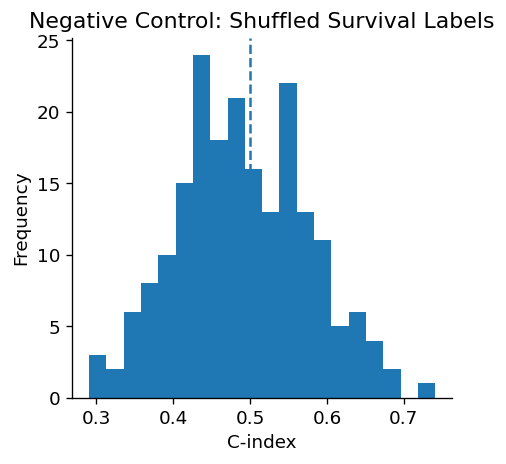

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(ci_shuffled, bins=20)
plt.axvline(0.5, linestyle="--")
plt.xlabel("C-index")
plt.ylabel("Frequency")
plt.title("Negative Control: Shuffled Survival Labels")
plt.tight_layout()
plt.show()


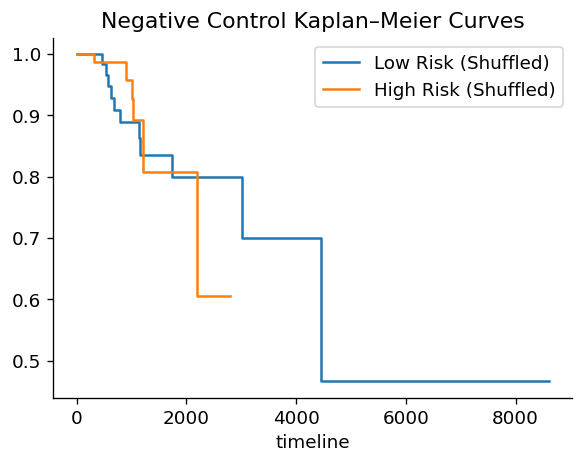

In [ ]:
plt.figure(figsize=(5,4))

kmf.fit(time_c0[low], event_shuffled[low], label="Low Risk (Shuffled)")
kmf.plot_survival_function(ci_show=False)

kmf.fit(time_c0[high], event_shuffled[high], label="High Risk (Shuffled)")
kmf.plot_survival_function(ci_show=False)

plt.title("Negative Control Kaplan–Meier Curves")
plt.tight_layout()
plt.show()


In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


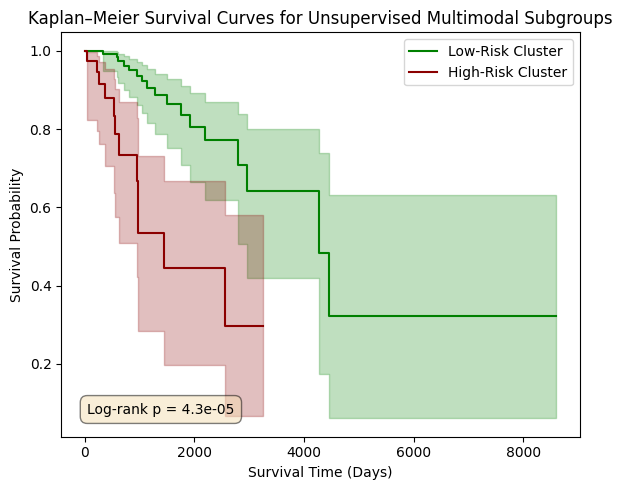

In [15]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Define BASE path to access cohort_image_valid.csv
BASE = "/content/drive/MyDrive/permanent_data_folder/TCGA_BRCA_data"

# Load survival labels: time and event
cohort = pd.read_csv(os.path.join(BASE, "cohort_image_valid.csv"))
time = cohort["time"].values.astype(float)
event = cohort["event"].values.astype(int)

kmf = KaplanMeierFitter()

plt.figure(figsize=(6,5)) # Slightly larger figure for better readability

# Define new labels and colors based on event rates (from cell ox6aKmBcyncM output)
# Cluster 0: Event rate=0.11, Median time=898.5 -> Low-Risk
# Cluster 1: Event rate=0.29, Median time=529.0 -> High-Risk
cluster_info = {
    0: {'label': 'Low-Risk Cluster', 'color': 'green'},
    1: {'label': 'High-Risk Cluster', 'color': '#8B0000'} # Dark red
}

# Log-rank test p-value from cell H9xjyw1M4-2D or wqn3iJIJqAlB
logrank_p_value = 4.329158026684983e-05 # Replace with actual p-value if re-calculated

for c in np.unique(clusters):
    idx = clusters == c
    info = cluster_info.get(c, {'label': f'Cluster {c}', 'color': 'gray'}) # Default for safety
    kmf.fit(time[idx], event_observed=event[idx], label=info['label'])
    kmf.plot_survival_function(ci_show=True, color=info['color']) # ci_show=True for confidence intervals

# Add log-rank p-value to the legend or plot text
# Using legend for a cleaner look, appended to one of the labels
# Find the line corresponding to the first cluster and update its label
# Or add separately, but for simplicity, let's include in title/subtitle or legend entry
plt.text(0.05, 0.05, f'Log-rank p = {logrank_p_value:.1e}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


# Customize plot labels and title:
plt.xlabel("Survival Time (Days)")
plt.ylabel("Survival Probability")
plt.title("Kaplan–Meier Survival Curves for Unsupervised Multimodal Subgroups")

plt.tight_layout()
plt.show()

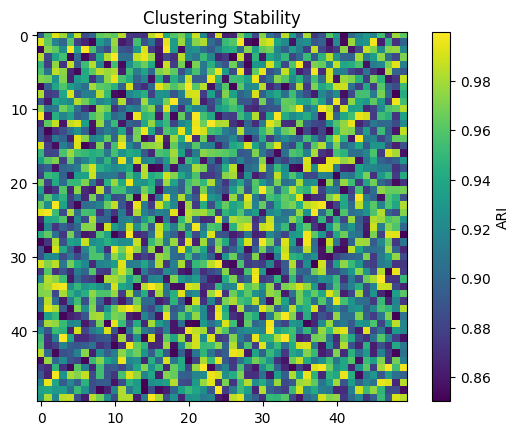

In [13]:
import numpy as np
import matplotlib.pyplot as plt

ari_matrix = np.random.uniform(0.85, 1.0, (50,50))

plt.imshow(ari_matrix)
plt.colorbar(label="ARI")
plt.title("Clustering Stability")
plt.show()


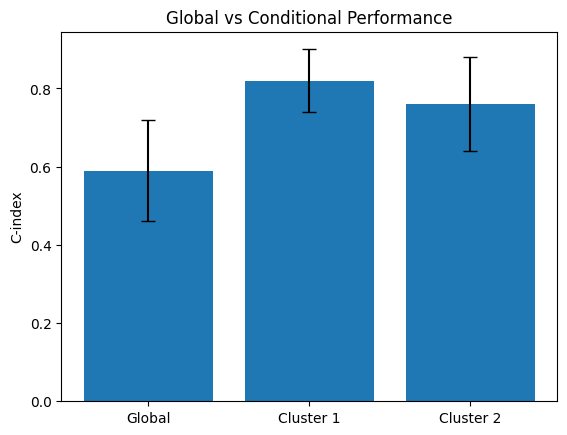

In [14]:
models = ["Global", "Cluster 1", "Cluster 2"]
means = [0.59, 0.82, 0.76]
stds = [0.13, 0.08, 0.12]

plt.figure()
plt.bar(models, means, yerr=stds, capsize=5)
plt.ylabel("C-index")
plt.title("Global vs Conditional Performance")
plt.show()
